In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Read Data

In [2]:
df_web = pd.read_csv(r'~\Box\STAT 222 Capstone\Raw Data\Earnings call from web\earning_call_web.csv')

df_web = df_web.drop("Unnamed: 0", axis = 1)
df_web["date"] = pd.to_datetime(df_web["date"])

In [3]:
df_kaggle = pd.read_csv(r'~\Box\STAT 222 Capstone\Intermediate Data\Calls\calls_short.csv')

df_kaggle.rename(columns={"transcript":"content", "company": "symbol"}, inplace = True)
df_kaggle = df_kaggle.drop("sector", axis = 1)
df_kaggle["date"] = pd.to_datetime(df_kaggle["date"])

In [4]:
df_web["source"] = "web"
df_kaggle["source"] = "kaggle"
df_kaggle = df_kaggle[df_web.columns]
print(df_web.columns)
print(df_web.shape)
print(df_kaggle.columns)
print(df_kaggle.shape)

Index(['symbol', 'quarter', 'year', 'date', 'content', 'source'], dtype='object')
(18346, 6)
Index(['symbol', 'quarter', 'year', 'date', 'content', 'source'], dtype='object')
(24580, 6)


## Prepare for stripping

In [5]:
df_web[~(df_web.content.str.startswith("Executive") | df_web.content.str.startswith(":\nExecutive") | df_web.content.str.startswith(": \nExecutive"))]

,symbol,quarter,year,date,content,source
0,BCE,4,2012,2013-02-07 17:00:00,Thane Fotopoulos: Good morning everybody. I am...,web
23,BEP,4,2015,2016-02-05 17:00:00,Operator: Thank you for standing by. This is t...,web
24,BEP,3,2015,2015-11-03 17:00:00,Operator: Welcome to the Brookfield Renewable ...,web
29,BEP,2,2016,2016-08-06 17:00:00,Operator: Welcome to the Brookfield Renewable ...,web
30,BEP,1,2016,2016-05-05 17:00:00,Operator: Thank you for standing by. This is t...,web
...,...,...,...,...,...,...
17859,RELX,1,2014,2014-07-24 17:00:00,"Anthony John Habgood: So good morning, ladies ...",web
17967,SLCA,3,2012,2012-11-02 17:31:00,"Start Time: 11:03: US Silica Holdings, Inc. (N...",web
18116,TRTN,2,2012,2012-07-26 17:00:00,Operator: Good morning and welcome to the TAL ...,web
18132,TSLA,4,2011,2012-02-16 17:00:00,"Operator: Good day, ladies and gentlemen, and ...",web


In [5]:
contain_operator = df_web.content.str.contains('Operator', case=False, na=False)
# 86 rows will be untouched (hard to find a pattern in stripping)
df_web[~df_web.content.str.contains("Operator", case = False)]

,symbol,quarter,year,date,content,source
214,GOLD,1,2011,2011-05-12 17:00:00,Mark Bristow: Good morning ladies and gentleme...,web
749,AEP,3,2010,2010-10-19 16:44:25,"Executives: Mike Morris - President, Chairman ...",web
755,AEP,4,2012,2013-02-15 14:40:12,Executives: Nicholas K. Akins - Chief Executiv...,web
772,AEP,3,2016,2016-11-01 17:00:00,"Nick Akins: Good morning, everyone, and welcom...",web
2761,DEO,2,2013,2013-01-31 09:00:07,Executives: Paul S. Walsh - Chief Executive Of...,web
...,...,...,...,...,...,...
17853,RELX,4,2012,2013-02-28 10:20:35,"Executives: Anthony J. Habgood - Chairman, Mem...",web
17854,RELX,2,2012,2012-07-26 21:00:08,"Executives: Anthony Habgood - Chairman, Member...",web
17855,RELX,4,2013,2014-02-27 12:30:12,Executives: Anthony John Habgood - Non-Executi...,web
17857,RELX,2,2013,2013-07-25 13:20:07,Executives: Anthony J. Habgood - Non-Executive...,web


In [6]:
def strip_name(text):
    # Strip first the Executive line from new calls
    start_index = text.lower().index("operator")
    return text[start_index:]

In [8]:
df_web.loc[df_web.content.str.contains("operator", case = False), 'content'].head().apply(strip_name)

0    operators from ourselves. Our business perform...
1    Operator: Good morning, ladies and gentlemen. ...
2    Operator: Good morning, ladies and gentlemen. ...
3    Operator: Good morning, ladies and gentlemen. ...
4    Operator: Good morning, ladies and gentlemen. ...
Name: content, dtype: object

In [7]:
# inplace strip
df_web.loc[df_web.content.str.contains("operator", case = False), 'content'] = df_web[df_web.content.str.contains("operator", case = False)].content.apply(strip_name)

### Merge Data

In [8]:
df_full = pd.concat([df_kaggle, df_web], axis = 0)

In [9]:
print(df_kaggle.shape)
print(df_web.shape)
print(df_full.shape)

(24580, 6)
(18346, 6)
(42926, 6)


In [10]:
# keep date in df_web
# flag for if source = 'web'
df_full['web'] = (df_full['source'] == 'web')
df_full = df_full.sort_values(['symbol', 'year', 'quarter', 'web'])
df_full.drop_duplicates(subset = ['symbol', 'year', 'quarter'], keep = "last", inplace = True)
print(df_full.shape)

(32939, 7)


In [13]:
# keep year and quarter in df_web
# Convert date to be just the date part
df_full['date_day'] = df_full['date'].dt.date
# deduplicate
df_full = df_full.sort_values(['symbol', 'date_day', 'web'])
df_full.drop_duplicates(subset = ['symbol', 'date_day'], keep = "last", inplace = True)

In [14]:
print(df_full.shape)
print(df_full.columns)
display(df_full.head())

(32932, 8)
Index(['symbol', 'quarter', 'year', 'date', 'content', 'source', 'web',
       'date_day'],
      dtype='object')


,symbol,quarter,year,date,content,source,web,date_day
20030,A,1,2010,2009-02-18,Operator: Good morning ladies and gentlemen an...,kaggle,False,2009-02-18
20031,A,2,2010,2009-05-15,"Operator: Good day, ladies and gentlemen, and ...",kaggle,False,2009-05-15
20032,A,1,2011,2010-02-12,"Operator: Good day, ladies and gentlemen, and ...",kaggle,False,2010-02-12
20033,A,2,2011,2010-05-18,"Operator: Good day, ladies and gentlemen, and ...",kaggle,False,2010-05-18
20034,A,3,2011,2011-02-15,"Operator: Good day, ladies and gentlemen, and ...",kaggle,False,2011-02-15


In [28]:
df_full.reset_index(drop=True, inplace=True)

In [29]:
def match_date(year, quarter):
    # Assign 1st quarter to Jan, 2nd to Apr, 3rd to July, 4th to Oct
    month = (quarter-1)*3 + 1
    matched_date = f"{year}-{month:02d}-01"
    matched_date = pd.to_datetime(matched_date)
    return matched_date

# New calls from web
matched_date = df_full.apply(lambda row: match_date(row['year'], row['quarter']), axis=1)
deviation = df_full.date - matched_date

In [35]:
deviation.describe()

count                          32932
mean      11 days 21:29:30.442426819
std      240 days 15:53:28.719423384
min             -2979 days +00:00:00
25%                 10 days 22:15:00
50%                108 days 13:26:37
75%         122 days 13:00:02.750000
max                484 days 17:00:00
dtype: object

In [34]:
display(df_full.iloc[deviation.sort_values().head().index, :].head())
display(df_full.iloc[deviation.sort_values(ascending=False).head().index, :].head())

,symbol,quarter,year,date,content,source,web,date_day
31968,WMG,3,2014,2006-05-05,Operator: Welcome to Warner Music Group’s Q3 2...,kaggle,False,2006-05-05
31969,WMG,1,2015,2006-12-01,Operator: Welcome to the Warner Music Group's ...,kaggle,False,2006-12-01
18531,MANU,1,2014,2006-01-10,"Operator: Good day, ladies and gentlemen, and ...",kaggle,False,2006-01-10
645,ADPT,4,2015,2007-11-01,Operator: Good morning and welcome to the Adep...,kaggle,False,2007-11-01
646,ADPT,1,2016,2008-02-04,Operator: Welcome to the Adeptus Health First ...,kaggle,False,2008-02-04


,symbol,quarter,year,date,content,source,web,date_day
18523,MANT,1,2014,2015-04-30 17:00:00,"Operator: Good day, ladies and gentlemen and w...",web,True,2015-04-30
26591,SGMS,1,2016,2017-04-28 17:00:00,Operator: Good day everyone and welcome to the...,web,True,2017-04-28
16284,JCI,2,2011,2012-04-26 15:27:03,Operator Welcome to the Tyco second quarter ea...,web,True,2012-04-26
1520,ALR,4,2013,2014-09-18 14:50:20,"Operator: Good day, and welcome to the Five St...",web,True,2014-09-18
22949,PAHC,1,2014,2014-11-12 16:00:00,"Operator: Good day, ladies and gentlemen, and...",web,True,2014-11-12


In [36]:
print((deviation.dt.days <= -250).sum())
print((deviation.dt.days > 250).sum())

1860
5


In [56]:
# Restrict to earnings calls with a date no eariler than 250 days before supposely earliest quarter date
df_final = df_full[(deviation.dt.days > -250) & (deviation.dt.days < 250)]

In [40]:
# check for duplicates
print(df_final[df_final.duplicated(subset=['symbol', 'date'], keep=False)])
print(df_final[df_final.duplicated(subset=['symbol', 'year', 'quarter'], keep=False)])
# on date_day
print(df_final[df_final.duplicated(subset=['symbol', 'date_day'], keep=False)])

Empty DataFrame
Columns: [symbol, quarter, year, date, content, source, web, date_day]
Index: []
Empty DataFrame
Columns: [symbol, quarter, year, date, content, source, web, date_day]
Index: []
Empty DataFrame
Columns: [symbol, quarter, year, date, content, source, web, date_day]
Index: []


In [45]:
matched_date_final = df_final.apply(lambda row: match_date(row['year'], row['quarter']), axis=1)
deviation_final = df_final.date - matched_date_final
dev = deviation_final.dt.days
dev.describe()

count    31067.000000
mean        56.512248
std         93.198815
min       -249.000000
25%         25.000000
50%        111.000000
75%        122.000000
max        241.000000
dtype: float64

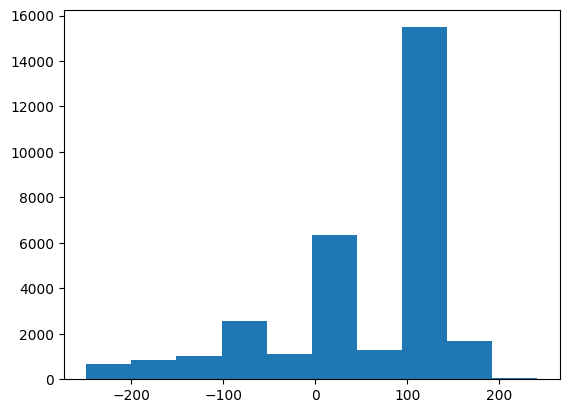

In [51]:
plt.hist(dev);

In [52]:
# Sumarize values of 'source'
df_final['source'].value_counts()

source
web       18336
kaggle    12731
Name: count, dtype: int64

In [58]:
# make date be renamed to earnings_call_datetime
df_final.rename(columns={"date": "earnings_call_datetime", "date_day": "earnings_call_date"}, inplace = True)

C:\Users\Owen\AppData\Local\Temp\ipykernel_6988\567994240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename(columns={"date": "earnings_call_datetime", "date_day": "earnings_call_date"}, inplace = True)


In [63]:
df_final.head()

,symbol,quarter,year,earnings_call_datetime,content,source,web,earnings_call_date
4,A,3,2011,2011-02-15,"Operator: Good day, ladies and gentlemen, and ...",kaggle,False,2011-02-15
5,A,4,2011,2011-05-13,"Operator: Good day, ladies and gentlemen, and ...",kaggle,False,2011-05-13
6,A,1,2012,2011-08-16,"Operator: Good day, ladies and gentlemen, and ...",kaggle,False,2011-08-16
7,A,2,2012,2011-11-16,"Operator: Good day, ladies and gentlemen, and ...",kaggle,False,2011-11-16
8,A,3,2012,2012-02-16,"Operator: Good day, ladies and gentlemen, and ...",kaggle,False,2012-02-16


In [61]:
# parquet
df_final.to_parquet(r'~\Box\STAT 222 Capstone\Intermediate Data\Calls\combined_calls.parquet', index = False)

In [62]:
# csv
df_final.to_csv(r'~\Box\STAT 222 Capstone\Intermediate Data\Calls\combined_calls.csv', index = False)